# Prova Técnica - Resolução

**Formato**: Problema Online + Entrevista subsequente

**Prazo**: 7 dias

**Descrição**: O problema consiste em prever a nota de avaliação dos clientes de um website de ecommerce, com base nos dados de avaliações (train_df.csv).

**Entregáveis**: link para repositório no Github com ao menos os seguintes arquivos:
- README.md
- notebook da solução (`resolução_prova_tecnica.ipynb`)
- source-code (`./src`)
- requirements.txt

**Dados**: train_df.csv
- Tabela de dados de empresa de ecommerce com mais de 130 mil avaliações de clientes. A base oferece informações sobre o perfil do revisor, como sexo, idade e localização geográfica.
    - y label column: overall_rating

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from textblob import TextBlob
import datetime
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.classifier import ROCAUC
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

In [2]:
df = pd.read_csv('data/train_df.csv', index_col=0)
print(f'Total de linhas: {df.shape[0]}')
print(df.info())
df.head()

Total de linhas: 105898
<class 'pandas.core.frame.DataFrame'>
Int64Index: 105898 entries, 95851 to 80345
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   submission_date        105898 non-null  object 
 1   reviewer_id            105898 non-null  object 
 2   product_id             105898 non-null  object 
 3   product_name           105833 non-null  object 
 4   product_brand          32704 non-null   object 
 5   site_category_lv1      105895 non-null  object 
 6   site_category_lv2      102686 non-null  object 
 7   review_title           105898 non-null  object 
 8   recommend_to_a_friend  105888 non-null  object 
 9   review_text            105898 non-null  object 
 10  reviewer_birth_year    101105 non-null  float64
 11  reviewer_gender        102582 non-null  object 
 12  reviewer_state         102691 non-null  object 
 13  overall_rating         105898 non-null  int64  
dtypes: float6

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,overall_rating
index,,,,,,,,,,,,,,
95851,2018-04-20 11:56:28,c951f3a4511b554a1f34330903c320f34cfccbdf8de357...,111586438,Depilador Elétrico Philips Satinelle HP6403/30,philips,Beleza e Perfumaria,Depilação,Depilador,Yes,Muito eficiente e prático! Depilação rápida em...,1978.0,F,ES,5
115536,2018-05-10 18:56:36,21da6d1c6d022a5c67da402d3082c7c438660f4252b7c3...,19399940,Hidratante Corporal Dior Addict Body Mist Femi...,NaN,Beleza e Perfumaria,Tratamento de Pele,Cheiro de rica,Yes,"Adoro o perfume que fica na pele, ele não é um...",1986.0,F,SP,5
1254,2018-01-02 07:02:48,eaf2f059cbb702e377bf95ac998aa4365f851937a3b419...,22747780,Controle Com Fio Para Xbox 360 Slim / Fat E Pc...,NaN,Games,Xbox 360,Bom produto,Yes,funciona o que é importante bom produto o text...,1978.0,M,ES,3
86792,2018-04-11 16:45:45,e5bb0709d14bc4a00aeaeb1f111616e69f57239dff7da6...,22857850,Kit Edredom + Lençol Aconchego Dupla Face Casa...,NaN,"Cama, Mesa e Banho",Edredom,Nao recebi onprofuto e nem satisfacao,No,Gostaria de saber da minha entrega ate hoje na...,1969.0,F,RJ,1
35543,2018-02-02 16:30:23,420a3ab1adf3c6010d491c8def04e19b1439ed01df7038...,132207708,Smartphone Motorola Moto E4 Dual Chip Android ...,motorola,Celulares e Smartphones,Smartphone,Excelente aquisição!,Yes,Entrega super rápida! Quando da compra tive c...,1965.0,M,PE,4


# Análise exploratória

## Submission date

In [3]:
df['submission_date'].value_counts()

2018-05-11 06:08:45    3
2018-01-04 06:34:10    3
2018-04-17 16:17:12    3
2018-05-26 16:57:01    3
2018-05-03 16:36:24    3
                      ..
2018-04-19 17:20:36    1
2018-03-18 16:28:02    1
2018-02-05 09:04:08    1
2018-01-10 07:24:18    1
2018-04-26 12:11:42    1
Name: submission_date, Length: 104296, dtype: int64

In [4]:
df['submission_date'].str.slice(0,4).value_counts()

2018    105898
Name: submission_date, dtype: int64

In [5]:
df['submission_date'].str.slice(5,7).value_counts()

01    27691
04    23942
03    23892
05    21118
02     9255
Name: submission_date, dtype: int64

Vemos que o campo tem alta cardinalidade, porém apenas vcalores de 2018 até maio. Iremos transformar ele em datas no futuro

## Reviewer_id

In [6]:
df['reviewer_id'].value_counts()

6ca0a1b3fa3b50ffa21e61a01633fd785172ebb04268d1ec97c7c958608902ea    125
1cd7f8704e3ebe899a8ff9b5bc485e787a703a67d0c66fce9c260de58e0340fe     62
2c213316c9638030e623f923e3fee14bf191cbab5777e8f5973cdb612b7675c8     56
363bf7b1a7505732379f7a2ae004ecbdc7194b5b774cd844ceebec9321d016b1     54
e34a8ba82a47141e5b2d7fbb53e8b7a7f4222ee64d27d2d4f5e4bf245a0fd4be     53
                                                                   ... 
2edf87ac89784b1d78c964f178ec20e87cbc57b770c9ceae49b60a2177b57066      1
033a35ce026ae0f03c5348d60d930af6786c7f5317c848e389c389535ee52694      1
2aa4e1c38f83af986c8e24601eb116277fe5cb1aecfcc8ad3b0b3b099d92e54b      1
faf6ed42cb50b256f9dd9b91740c2ca555836826155dd80df9b458108df6863c      1
d38cf20f84d0f0e12beddd082e497863f378f0a6433151e04ba03f2118201816      1
Name: reviewer_id, Length: 92568, dtype: int64

Como esperado, o cliente/reviewer também tem alta cardinalidade.

In [7]:
print(pd.DataFrame(df['reviewer_id'].value_counts()).describe())
print(f'percentil 99: {df["reviewer_id"].value_counts().quantile(0.99)}')

        reviewer_id
count  92568.000000
mean       1.144002
std        0.797427
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max      125.000000
percentil 99: 3.0


Podemos ver que 99% dos clientes comparam 3 ou menos vezes. Podemos criar features de clientes que usam bastante o site para o ML

## product_id

In [8]:
df['product_id'].value_counts()

132444092    631
126474851    594
128010777    519
132444050    469
129543938    408
            ... 
113097339      1
8231754        1
22368452       1
29544505       1
121871232      1
Name: product_id, Length: 40964, dtype: int64

In [9]:
print(pd.DataFrame(df['product_id'].value_counts()).describe())
print(f'percentil 99: {df["product_id"].value_counts().quantile(0.99)}')

         product_id
count  40964.000000
mean       2.585148
std       11.117728
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max      631.000000
percentil 99: 26.0


Basicamente o mesmo comportamento do reviewer_id e podemos também criar a feature de produto "famoso"

## product_name

In [10]:
df['product_name'].value_counts()

Smartphone Motorola Moto G 5S Dual Chip Android 7.1.1 Nougat Tela 5.2" Snapdragon 430 32GB 4G Câmera 16MP - Platinum    631
Aspirador de Pó Philco Rapid 1000N Vermelho/Preto - 1000W                                                               594
Smartphone Samsung Galaxy J7 Metal Dual Chip Android 6.0 Tela 5.5" 16GB 4G Câmera 13MP - Dourado                        519
Smartphone Motorola Moto G 5S Dual Chip Android 7.1.1 Nougat Tela 5.2" Snapdragon 430 32GB 4G Câmera 16MP - Dourado     469
Smartphone Samsung Galaxy J7 Prime Dual Chip Android Tela 5.5" 32GB 4G Câmera 13MP - Dourado                            408
                                                                                                                       ... 
Lavagem A Seco Detergente Lave Seco 500g Mills                                                                            1
Berço Toybar Azul - Cosco                                                                                                 1
Poder da

In [11]:
print(pd.DataFrame(df['product_name'].value_counts()).describe())
print(f'percentil 99: {df["product_name"].value_counts().quantile(0.99)}')

       product_name
count  40445.000000
mean       2.616714
std       11.220170
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max      631.000000
percentil 99: 27.0


Essa feature se assemelha com o product_id e iremos ignorar em futuras analises já que elas se relacionam à mesma coisa

## product_brand

In [12]:
df['product_brand'].value_counts()

samsung             4841
lg                  2347
philco              2158
cadence             1117
mondial             1023
                    ... 
benetton               1
u.s. polo              1
full-fit               1
jolitex ternille       1
di angelo              1
Name: product_brand, Length: 985, dtype: int64

In [13]:
print(pd.DataFrame(df['product_brand'].value_counts()).describe())
print(f'percentil 99: {df["product_brand"].value_counts().quantile(0.99)}')

       product_brand
count     985.000000
mean       33.202030
std       206.534124
min         1.000000
25%         1.000000
50%         3.000000
75%        11.000000
max      4841.000000
percentil 99: 716.2799999999982


Temos uma quantidade de marcas interessante pro problema, porem muitos nulos. A maioria das marcas tem poucas avaliações (75% < 11), porém algumas marcas tem bastante avaliações. Podemos considerar onehot nas marcas mais famosas e as outras como "outras" e/ou "nan".\
Uma opção para os NaNs seria fazer a distancia entre as strings do nome do produto e ver a marca do mais perto (caso existe; se não o segundo mais perto e asism por diante) para dar replace nos NaNs. Como seria um processo demorado e pesado por causa da alta cardinalidade do nome do produto, ignorarei isso.

## site_category_lv1

In [14]:
df['site_category_lv1'].value_counts()

Celulares e Smartphones           16605
Eletroportáteis                    9398
Beleza e Perfumaria                7155
Utilidades Domésticas              6579
TV e Home Theater                  6071
Informática e Acessórios           5985
Móveis                             5738
Brinquedos                         3732
Casa e Construção                  3527
Informática                        3419
Livros                             3397
Automotivo                         3110
Eletrodomésticos                   3076
Games                              2847
Bebês                              2425
Esporte e Lazer                    2355
Cama, Mesa e Banho                 2352
Saúde                              2197
Moda                               1992
Ferramentas e Jardim               1417
Áudio                              1194
Decoração                          1179
Relógios                           1176
Pet Shop                           1086
Suplementos e Vitaminas             982


<AxesSubplot:label='c677cfd9-c48b-425c-8ea9-cea2a3ffffca', ylabel='cumsum'>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


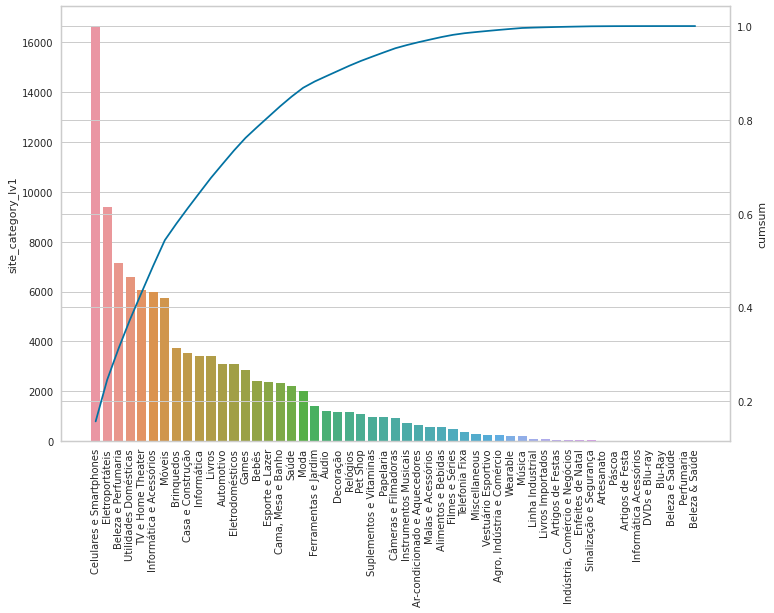

In [15]:
temp_ = pd.DataFrame(df['site_category_lv1'].value_counts(), columns=['site_category_lv1'])
temp_['cumsum'] = temp_['site_category_lv1'].cumsum()/temp_['site_category_lv1'].sum()

f,ax = plt.subplots(figsize=(12,8))
plt.xticks(rotation=90)
sns.barplot( y = temp_['site_category_lv1'] , x = temp_.index , ax=ax)
ax2 = plt.twinx()
sns.lineplot(y = temp_['cumsum'] , x = temp_.index, color="b", ax=ax2)

Conseguimos ver quais categorias no site tem mais reviews. No futuro irei separar entre as maiores categorias

## site_category_lv2

In [16]:
df['site_category_lv2'].value_counts()

Smartphone                  14089
TV                           4911
Cabelo                       2044
Notebook                     1948
Acessórios para Celular      1853
                            ...  
Bolos                           1
Frutas                          1
Disney Infinity                 1
Quadrinhos e HQs                1
Descartáveis para Festa         1
Name: site_category_lv2, Length: 702, dtype: int64

<AxesSubplot:label='68dc60db-e91b-4532-8991-9af7372396c2', ylabel='cumsum'>

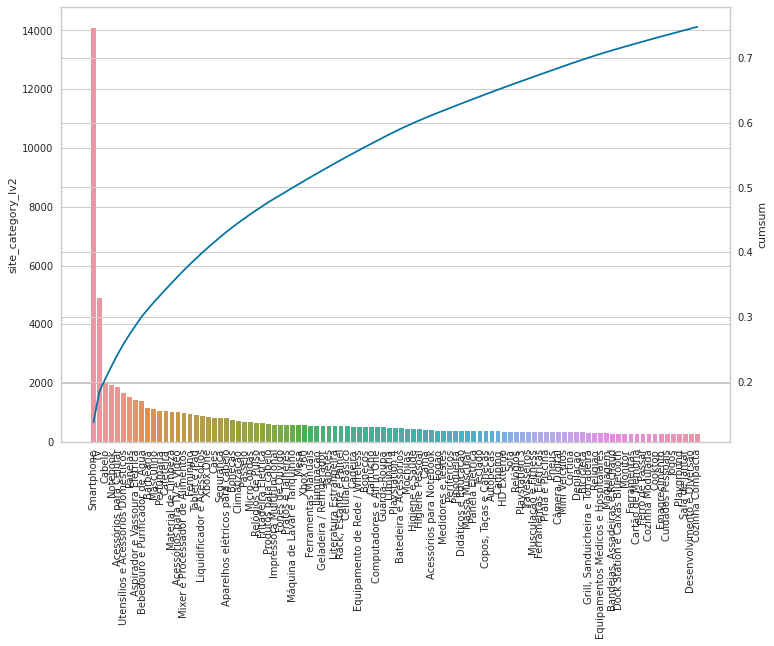

In [17]:
temp_ = pd.DataFrame(df['site_category_lv2'].value_counts(), columns=['site_category_lv2'])
temp_['cumsum'] = temp_['site_category_lv2'].cumsum()/temp_['site_category_lv2'].sum()
temp_ = temp_[temp_['cumsum']<=0.75]
f,ax = plt.subplots(figsize=(12,8))
plt.xticks(rotation=90)
sns.barplot( y = temp_['site_category_lv2'] , x = temp_.index , ax=ax)
ax2 = plt.twinx()
sns.lineplot(y = temp_['cumsum'] , x = temp_.index, color="b", ax=ax2)

Mesmo filtrando só as categorias que chegam a 75% dos dados, temos muitas sub categorias. Usarei então apenas o top 30% destas.

<AxesSubplot:label='253f78a9-73ce-45ed-9e8b-667724815efe', ylabel='cumsum'>

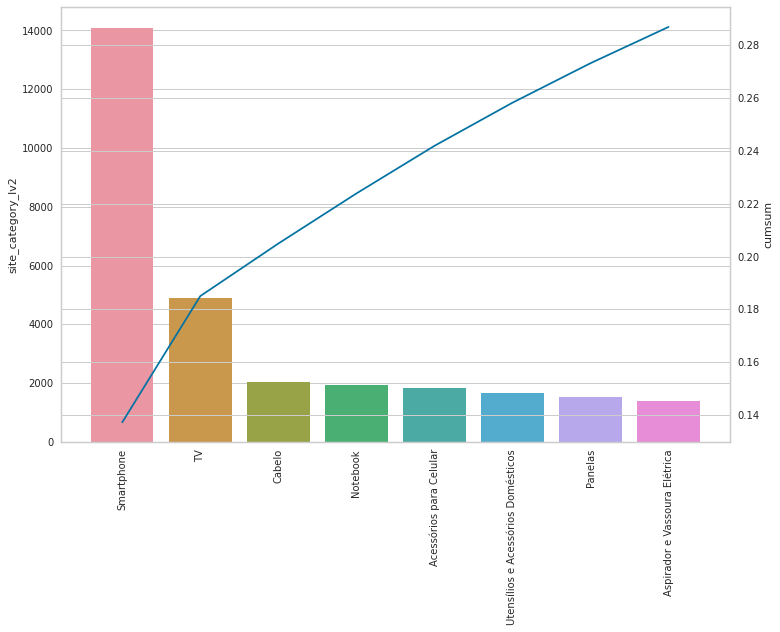

In [18]:
temp_ = pd.DataFrame(df['site_category_lv2'].value_counts(), columns=['site_category_lv2'])
temp_['cumsum'] = temp_['site_category_lv2'].cumsum()/temp_['site_category_lv2'].sum()
temp_ = temp_[temp_['cumsum']<=0.3]
f,ax = plt.subplots(figsize=(12,8))
plt.xticks(rotation=90)
sns.barplot( y = temp_['site_category_lv2'] , x = temp_.index , ax=ax)
ax2 = plt.twinx()
sns.lineplot(y = temp_['cumsum'] , x = temp_.index, color="b", ax=ax2)

## recommend_to_a_friend

In [19]:
df['recommend_to_a_friend'].value_counts()

Yes    77000
No     28888
Name: recommend_to_a_friend, dtype: int64

<AxesSubplot:xlabel='recommend_to_a_friend', ylabel='count'>

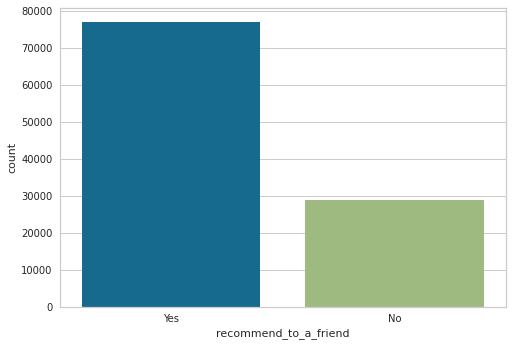

In [20]:
sns.countplot(x = df['recommend_to_a_friend'])

Ordem de grandeza está ok entre as duas classes

## reviewer_birth_year

In [21]:
df['reviewer_birth_year'].value_counts()

1982.0    3490
1981.0    3467
1983.0    3389
1984.0    3350
1980.0    3338
          ... 
1914.0       1
1915.0       1
1916.0       1
1917.0       1
2018.0       1
Name: reviewer_birth_year, Length: 113, dtype: int64

(1900.0, 2050.0)

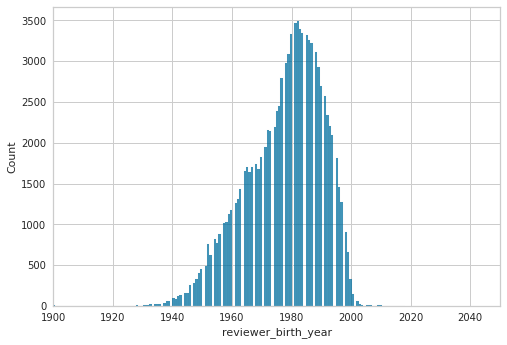

In [22]:
sns.histplot(df['reviewer_birth_year'])
plt.xlim(1900,2050)

In [23]:
df['reviewer_birth_year'].describe()

count    101105.000000
mean       1977.532872
std          21.236195
min          59.000000
25%        1969.000000
50%        1980.000000
75%        1987.000000
max        2018.000000
Name: reviewer_birth_year, dtype: float64

Temos alguns valores estranhos (59??) porém a maioria está ok para o que se espera da idade atual de clientes de um site

## reviewer_gender

<AxesSubplot:xlabel='reviewer_gender', ylabel='count'>

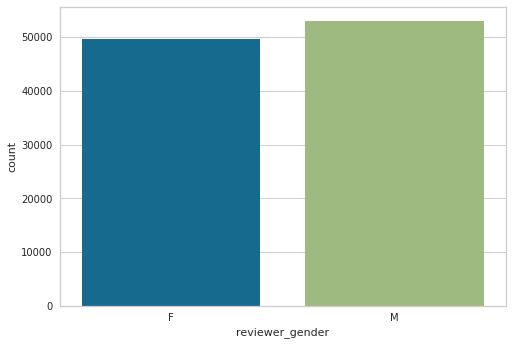

In [24]:
sns.countplot(x = df['reviewer_gender'])

Gênero dos clientes são bem balanceados

## reviewer_state

<AxesSubplot:xlabel='reviewer_state', ylabel='count'>

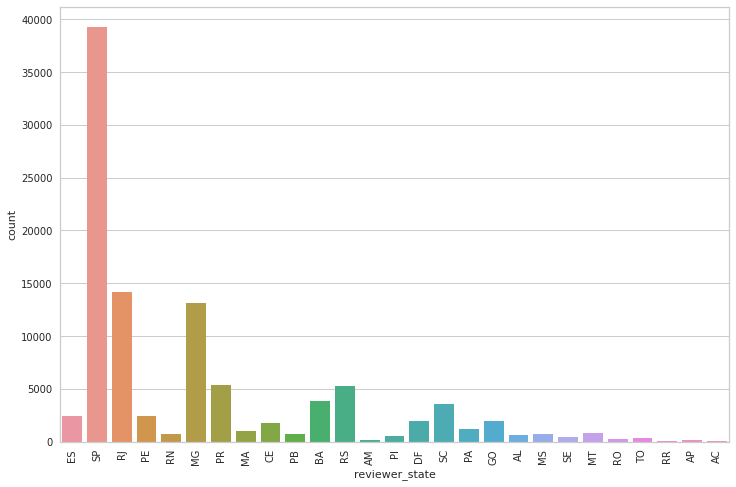

In [25]:
f, ax = plt.subplots(figsize=(12,8))
plt.xticks(rotation=90)
sns.countplot(x = df['reviewer_state'], ax=ax)


Nota-se que a maioria dos reviews encontram no sudeste (SP/MG/RJ)

## review_title

In [26]:
df['review_title']

index
95851                                 Depilador
115536                           Cheiro de rica
1254                                Bom produto
86792     Nao recebi onprofuto e nem satisfacao
35543                      Excelente aquisição!
                          ...                  
25369                       muito bom o produto
113035                  Gostei muito do produto
40265                        Veio sem funcionar
34846     Sofá excelente e entrega muito rápida
80345                     Ótimo custo benefício
Name: review_title, Length: 105898, dtype: object

Título do review claramente são textos livres. Por mais que o campo seja pequeno, irei criar o sentimento dele por curiosidade

<AxesSubplot:xlabel='sentiment_title', ylabel='Count'>

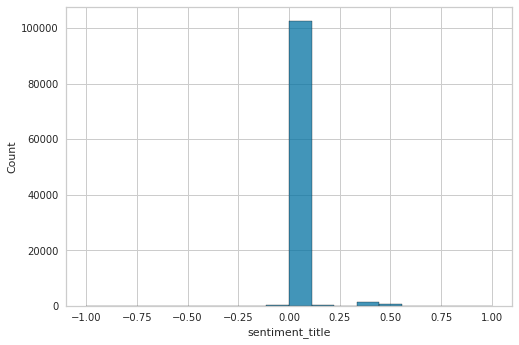

In [27]:
df['sentiment_title'] = df['review_title'].apply(lambda x: TextBlob(x).sentiment.polarity)
sns.histplot(data=df, x = 'sentiment_title')

Realmente não podemos tirar conclusão deste título usando o sentimento. Vamos ver o que acontece com o texto do review.

## review_text

In [28]:
df['sentiment_text'] = df['review_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

<AxesSubplot:xlabel='sentiment_text', ylabel='Count'>

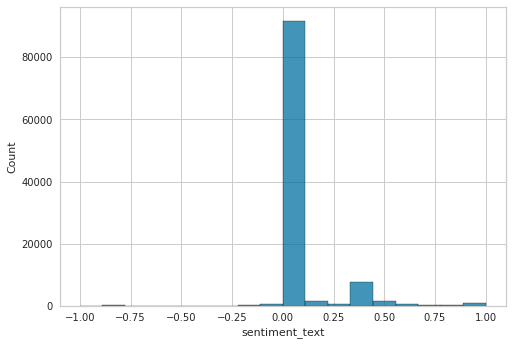

In [29]:
sns.histplot(data=df, x = 'sentiment_text')

Também é dificil tirar conclusões pois tudo está muito perto de 0

In [30]:
df['len_review'] = df['review_text'].str.len()
df['words_review'] = df['review_text'].str.split().apply(lambda x: len(x))


In [31]:
df[['len_review','words_review']].describe()

,len_review,words_review
count,105898.000000,105898.000000
mean,141.711335,23.865276
std,137.391151,23.915297
min,50.000000,1.000000
25%,68.000000,11.000000
50%,97.000000,16.000000
75%,160.000000,27.000000
max,4548.000000,795.000000


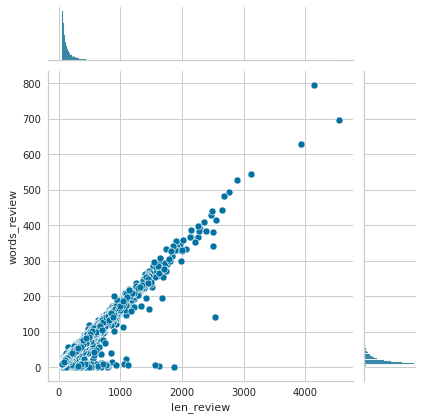

In [32]:
sns.jointplot(x ='len_review', y='words_review', data=df )

## overall_rating

<AxesSubplot:xlabel='overall_rating', ylabel='count'>

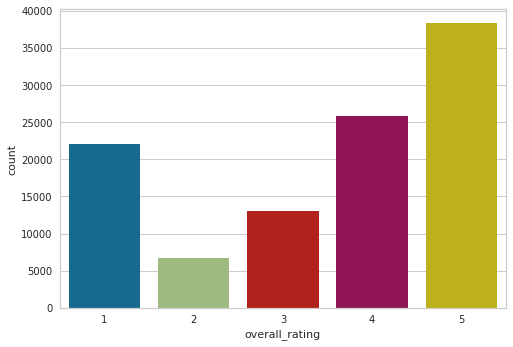

In [33]:
sns.countplot(x = 'overall_rating', data=df)

Dados bem distribuidos entre as diferentes classes.\
Vamos ver como algumas variáveis se comportam em relação à ele

<AxesSubplot:xlabel='recommend_to_a_friend', ylabel='overall_rating'>

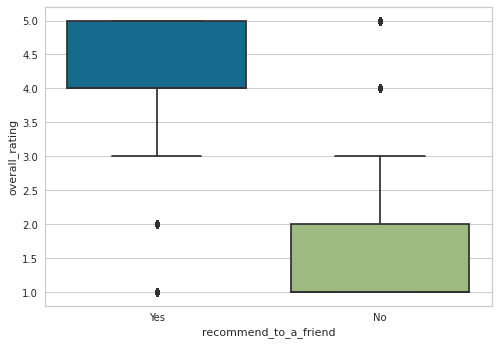

In [34]:
sns.boxplot(y ='overall_rating', x='recommend_to_a_friend', data=df )

Como esperado, se a pessoa recomendaria para um amigo, grandes chance dele ter avaliado melhor o produto

<AxesSubplot:xlabel='reviewer_gender', ylabel='overall_rating'>

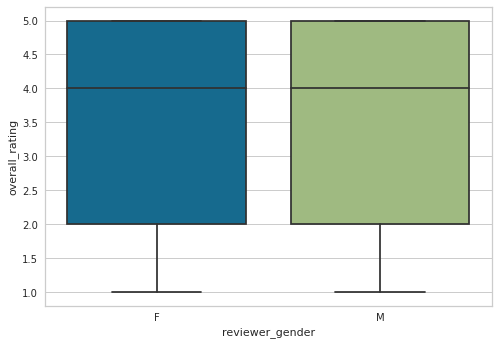

In [35]:
sns.boxplot(y ='overall_rating', x='reviewer_gender', data=df )

Não há difirença nas avaliações dadas entre homens e mulheres

<AxesSubplot:xlabel='reviewer_state', ylabel='overall_rating'>

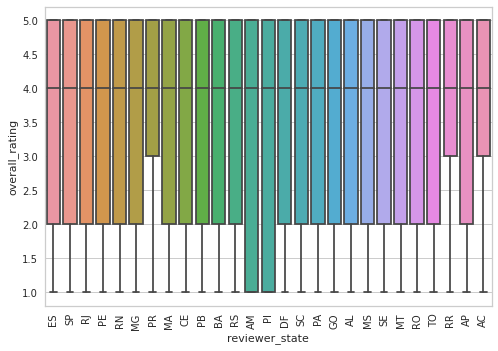

In [36]:
plt.xticks(rotation=90)
sns.boxplot(y ='overall_rating', x='reviewer_state', data=df )


Também não há grandes diferenças considerando o estado, apenas que AM e PI tem noitas mais notas menores do que a maioria, e que PR, RR e AC levemente maiores.

(0.0, 600.0)

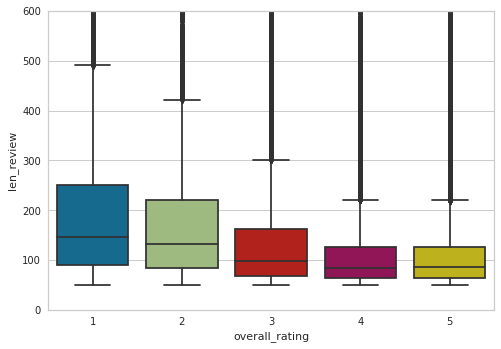

In [37]:
sns.boxplot(y ='len_review', x='overall_rating', data=df)
plt.ylim(0,600)

Nota-se que quanto maior o review, menor a nota do review

# Feature Eng & Pipeline

In [38]:
#Setando transformando algumas variáveis
df['submission_date'] = pd.to_datetime(df['submission_date'])
df['product_brand'] = df['product_brand'].fillna("Unknown")

df['mes'] = df['submission_date'].dt.month_name()
df['dia'] = df['submission_date'].dt.day_name()

df = df.dropna()
df.head()

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,overall_rating,sentiment_title,sentiment_text,len_review,words_review,mes,dia
index,,,,,,,,,,,,,,,,,,,,
95851,2018-04-20 11:56:28,c951f3a4511b554a1f34330903c320f34cfccbdf8de357...,111586438,Depilador Elétrico Philips Satinelle HP6403/30,philips,Beleza e Perfumaria,Depilação,Depilador,Yes,Muito eficiente e prático! Depilação rápida em...,1978.0,F,ES,5,0.0,0.000000,147,23,April,Friday
115536,2018-05-10 18:56:36,21da6d1c6d022a5c67da402d3082c7c438660f4252b7c3...,19399940,Hidratante Corporal Dior Addict Body Mist Femi...,Unknown,Beleza e Perfumaria,Tratamento de Pele,Cheiro de rica,Yes,"Adoro o perfume que fica na pele, ele não é um...",1986.0,F,SP,5,0.0,0.000000,146,25,May,Thursday
1254,2018-01-02 07:02:48,eaf2f059cbb702e377bf95ac998aa4365f851937a3b419...,22747780,Controle Com Fio Para Xbox 360 Slim / Fat E Pc...,Unknown,Games,Xbox 360,Bom produto,Yes,funciona o que é importante bom produto o text...,1978.0,M,ES,3,0.0,0.000000,122,24,January,Tuesday
86792,2018-04-11 16:45:45,e5bb0709d14bc4a00aeaeb1f111616e69f57239dff7da6...,22857850,Kit Edredom + Lençol Aconchego Dupla Face Casa...,Unknown,"Cama, Mesa e Banho",Edredom,Nao recebi onprofuto e nem satisfacao,No,Gostaria de saber da minha entrega ate hoje na...,1969.0,F,RJ,1,0.0,0.000000,72,12,April,Wednesday
35543,2018-02-02 16:30:23,420a3ab1adf3c6010d491c8def04e19b1439ed01df7038...,132207708,Smartphone Motorola Moto E4 Dual Chip Android ...,motorola,Celulares e Smartphones,Smartphone,Excelente aquisição!,Yes,Entrega super rápida! Quando da compra tive c...,1965.0,M,PE,4,0.0,0.520833,378,64,February,Friday


Transformando algumas features

In [39]:
def is_top_threshold(data, coluna, threshold):
    # Função que retorna se uma categoria está na top threshold de categorias 
    principais = pd.DataFrame(data[coluna].value_counts().reset_index())
    principais['cumsum'] = principais[coluna].cumsum()/principais[coluna].sum()
    principais = principais[principais['cumsum']<=threshold]
    
    data.loc[:,'is_top%'] = np.where(data[coluna].isin(principais['index']),1,0)
    return data['is_top%']




# 5% dos clientes com mais reviews
df['top_reviewes'] = is_top_threshold(df, 'reviewer_id', 0.05)
#5% most solds products
df['is_most_sold'] = is_top_threshold(df, 'product_id', 0.05)
#Tops sites categories
df['top_cat_lv1'] = is_top_threshold(df, 'site_category_lv1', 0.05)
df['top_cat_lv2'] = is_top_threshold(df, 'site_category_lv2', 0.05)

df['recommend_to_a_friend'] = df['recommend_to_a_friend'].map({'Yes':True, 'No':False})
df['age'] = 2022-df['reviewer_birth_year']
df['reviewer_gender'] = df['reviewer_gender'].map({'M':0, 'F':1})

#variaveis cícliclas
df['sin_time'] = np.sin(2*np.pi*df['submission_date'].dt.round('30T').dt.hour/24)
df['cos_time'] = np.cos(2*np.pi*df['submission_date'].dt.round('30T').dt.hour/24)



In [40]:
X = df[[x for x in df.columns if x != 'overall_rating']]
y = df['overall_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

feats_numericas = ["reviewer_gender", "sentiment_text","len_review","words_review",
                  "is_top%" ,"top_reviewes" ,'is_most_sold','top_cat_lv1','top_cat_lv2','age',
                  'sin_time', 'cos_time', 'recommend_to_a_friend']

transformer_numerico = Pipeline(steps=[("fillna", SimpleImputer(strategy="mean")), 
                                       ("scaler", MinMaxScaler())])

#adicionand dia com categoria para não precisar criar variavel cíclica dela também
feats_categoricas = ["product_brand", "site_category_lv1", "site_category_lv2", "reviewer_state", "mes","dia"]
onehot = OneHotEncoder()

tfidf = TfidfVectorizer(encoding = 'latin1', 
                        stop_words=list(stopwords.words('portuguese')))

transformador = ColumnTransformer(
    transformers=[("numerico", transformer_numerico, feats_numericas),
                  ("cat", onehot, feats_categoricas),
                  #('tfidf', tfidf, ['review_text'])
                 ],
    remainder='drop')

## Logistica

In [41]:
logistica = Pipeline(
    steps=[("preprocessamento", transformador), ("regressao", LogisticRegression())]
)

param_search = {'regressao__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                'regressao__C': [0.2,0.5,0.8,1],
                'preprocessamento__cat__handle_unknown': ['infrequent_if_exist','ignore'],
                #'preprocessamento__tfidf__max_df': [0.9,0.75,0.8],
                #'preprocessamento__tfidf__min_df': [0.08,0.3]
               }

modelolog = RandomizedSearchCV(logistica, 
                            param_distributions = param_search,
                            n_jobs=4,
                            scoring = 'accuracy',
                            n_iter=40,
                            cv=10,
                            random_state=42)

modelolog.fit(X_train, y_train)
print(f"Score dos dados de treinamento: {modelolog.best_score_}")
print(f"Score dos dads não vistos {modelolog.score(X_test, y_test)}")

Score dos dados de treinamento: 0.5508743334222463
Score dos dads não vistos 0.5546029802000408


Não temos overfitting, modelo performando pouco

In [42]:
pd.DataFrame(confusion_matrix(y_test, modelolog.predict(X_test)))

,0,1,2,3,4
0,4959,2,6,30,116
1,1147,2,20,70,277
2,342,1,95,537,2145
3,90,0,80,895,4939
4,108,0,70,930,7634


In [43]:
def roc_multiclasse(model, xtrain, ytrain, xtest, ytest):
    grafico = ROCAUC(model, encoder={1: 1, 2: 2, 3:3, 4:4,5:5})                              
    grafico.fit(xtrain, ytrain)
    grafico.score(xtest, ytest)
    grafico.show()
    return grafico

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


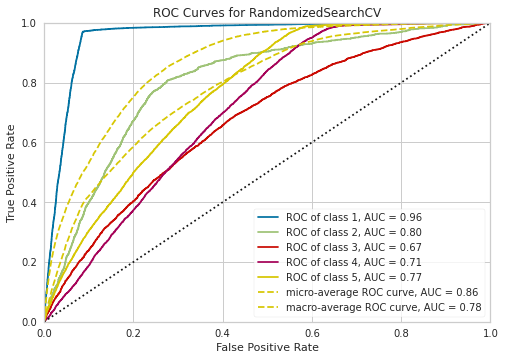

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomizedSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={1: 1, 2: 2, 3: 3, 4: 4, 5: 5},
       estimator=RandomizedSearchCV(cv=10,
                                    estimator=Pipeline(steps=[('preprocessamento',
                                                               ColumnTransformer(transformers=[('numerico',
                                                                                                Pipeline(steps=[('fillna',
                                                                                                                 SimpleImputer()),
                                                                                                                ('scaler',
                                                                                                                 MinMaxScaler())...
                                                                                                ['product_brand',
                                                                                                 'site_category_lv1',
                                                                                                 'site_category_lv2',
                                                                                                 'reviewer_state',
                                                                                                 'mes',
                                                                                                 'dia'])])),
                                                              ('regressao',
                                                               LogisticRegression())]),
                                    n_iter=40, n_jobs=4,
                                    param_distributions={'preprocessamento__cat__handle_unknown': ['infrequent_if_exist',
                                                                                                   'ignore'],
                                                         'regressao__C': [0.2,
                                                                          0.5,
                                                                          0.8,
                                                                          1],
                                                         'regressao__penalty': ['l1',
                                                                                'l2',
                                                                                'elasticnet',
                                                                                'none']},
                                    random_state=42, scoring='accuracy'))

In [44]:
roc_multiclasse(modelolog, X_train, y_train, X_test, y_test)

## RF Classifier

In [45]:
rf = Pipeline(
    steps=[("preprocessamento", transformador), ("classifier", RandomForestClassifier())]
)

param_search = {'classifier__criterion': ['gini', 'entropy'],
                'classifier__max_depth': [3,5,8,None],
                'classifier__min_samples_split':[2,10,0.1,0.2,0.05],
                'classifier__min_samples_leaf': [2,10,0.1,0.2,0.05],
                'preprocessamento__cat__handle_unknown': ['infrequent_if_exist','ignore']
               }

modelorf = RandomizedSearchCV(rf, 
                            param_distributions = param_search,
                            n_jobs=4,
                            scoring = 'accuracy',
                            n_iter= 50,
                            cv=10,
                            random_state=42)


modelorf.fit(X_train, y_train)
print(f"Score dos dados de treinamento: {modelorf.best_score_}")
print(f"Score dos dads não vistos {modelorf.score(X_test, y_test)}")

Score dos dados de treinamento: 0.5498400772645385
Score dos dads não vistos 0.5528066952439273


Sem overfit

In [46]:
pd.DataFrame(confusion_matrix(y_test, modelorf.predict(X_test)))

,0,1,2,3,4
0,4894,0,0,0,219
1,1123,0,0,1,392
2,356,0,0,1,2763
3,93,0,0,4,5907
4,98,0,0,1,8643


 O modelo aparenta não estar conseguindo diferenciar bem entre as classes. Vamos ver o que acontece com o feat importance do random forest:

In [47]:
sorted(list(zip(modelorf.best_estimator_['preprocessamento'].get_feature_names_out(),
                modelorf.best_estimator_['classifier'].feature_importances_)), 
       key= lambda x: x[1], reverse=True)

[('numerico__recommend_to_a_friend', 0.6081616104710521),
 ('numerico__words_review', 0.07642202511686312),
 ('numerico__len_review', 0.07138938202081596),
 ('numerico__sentiment_text', 0.027510217553807365),
 ('cat__product_brand_Unknown', 0.013004216964128444),
 ('numerico__age', 0.01180732941638999),
 ('cat__site_category_lv2_Smartphone', 0.011345788903824535),
 ('cat__site_category_lv1_Móveis', 0.008749287623900216),
 ('cat__site_category_lv1_Livros', 0.008585731352806223),
 ('numerico__is_most_sold', 0.006779554200371496),
 ('numerico__sin_time', 0.006551951436172053),
 ('numerico__cos_time', 0.005549641827266502),
 ('cat__site_category_lv1_Celulares e Smartphones', 0.004128448742041766),
 ('cat__site_category_lv2_Acessórios para Celular', 0.003805897277445522),
 ('cat__site_category_lv1_Eletroportáteis', 0.0033831420136137412),
 ('cat__product_brand_samsung', 0.0030268234653097665),
 ('numerico__reviewer_gender', 0.0029137937466860654),
 ('numerico__top_reviewes', 0.0028145156104

Claramente se o cliente recomenda o produto está pesando muito para a "binarização" das notas do random forest classifier

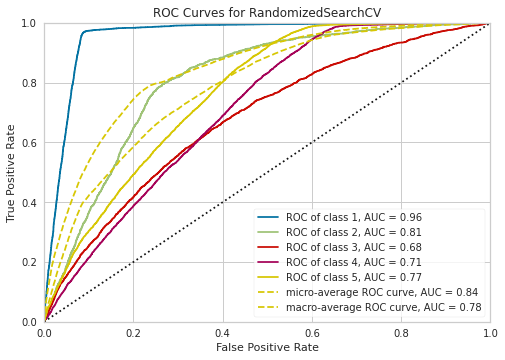

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomizedSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={1: 1, 2: 2, 3: 3, 4: 4, 5: 5},
       estimator=RandomizedSearchCV(cv=10,
                                    estimator=Pipeline(steps=[('preprocessamento',
                                                               ColumnTransformer(transformers=[('numerico',
                                                                                                Pipeline(steps=[('fillna',
                                                                                                                 SimpleImputer()),
                                                                                                                ('scaler',
                                                                                                                 MinMaxScaler())...
                                                               RandomForestClassifier())]),
                                    n_iter=50, n_jobs=4,
                                    param_distributions={'classifier__criterion': ['gini',
                                                                                   'entropy'],
                                                         'classifier__max_depth': [3,
                                                                                   5,
                                                                                   8,
                                                                                   None],
                                                         'classifier__min_samples_leaf': [2,
                                                                                          10,
                                                                                          0.1,
                                                                                          0.2,
                                                                                          0.05],
                                                         'classifier__min_samples_split': [2,
                                                                                           10,
                                                                                           0.1,
                                                                                           0.2,
                                                                                           0.05],
                                                         'preprocessamento__cat__handle_unknown': ['infrequent_if_exist',
                                                                                                   'ignore']},
                                    random_state=42, scoring='accuracy'))

In [48]:
roc_multiclasse(modelorf, X_train, y_train, X_test, y_test)

## Regressão Linear

In [49]:
linear = Pipeline(
    steps=[("preprocessamento", transformador), ("regressao", LinearRegression())]
)

param_search = {'regressao__fit_intercept': [True, False],
                'regressao__positive': [True, False],
                'preprocessamento__cat__handle_unknown': ['infrequent_if_exist','ignore']
               }

modelo_linear = RandomizedSearchCV(linear, 
                            param_distributions = param_search,
                            n_jobs=4,
                            scoring = 'r2',
                            n_iter= 8,
                            cv=10,
                            random_state=42)


modelo_linear.fit(X_train, y_train)
print(f"Score dos dados de treinamento: {modelo_linear.best_score_}")
print(f"Score dos dads não vistos {modelo_linear.score(X_test, y_test)}")

Score dos dados de treinamento: 0.706836470499868
Score dos dads não vistos 0.7119186233979471


In [50]:
mean_absolute_error(y_test,modelo_linear.predict(X_test))

0.652216630736148

Text(0.5, 1.0, 'Histograma dos valores previstos pelo modelo')

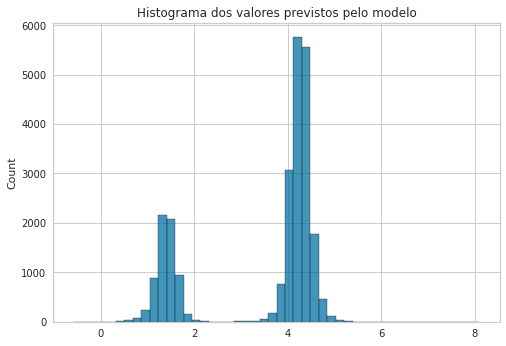

In [51]:
sns.histplot(modelo_linear.predict(X_test))
plt.title('Histograma dos valores previstos pelo modelo')

Text(0.5, 1.0, 'Histograma dos valores previstos peloo modelo \n (corrigido para inteiro e dentro do intervalo esperado)')

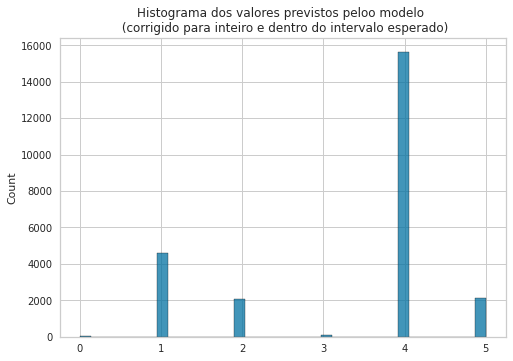

In [52]:
sns.histplot([round(x) for x in np.clip(modelo_linear.predict(X_test),0,5)])
plt.title('Histograma dos valores previstos peloo modelo \n (corrigido para inteiro e dentro do intervalo esperado)')

In [53]:
confusion_matrix(y_test,[round(x) for x in np.clip(modelo_linear.predict(X_test), 0,5)])

array([[   0,    0,    0,    0,    0,    0],
       [  16, 3502, 1440,    3,  146,    6],
       [   3,  785,  360,    4,  349,   15],
       [   2,  221,  120,   17, 2601,  159],
       [   0,   32,   58,   22, 5364,  528],
       [   0,   37,   72,   30, 7163, 1440]])

In [54]:
accuracy_score(y_test, [round(x) for x in np.clip(modelo_linear.predict(X_test), 0,5)])

0.4361298224127373

## XGBoost

In [61]:
xgboost = Pipeline(
    steps=[("preprocessamento", transformador), ("classifier", GradientBoostingClassifier(max_features='sqrt'))]
)

param_search = {'classifier__max_depth': [3,5,8,None],
                'classifier__min_samples_split':[2,10,0.1,0.2,0.05],
                'classifier__min_samples_leaf': [2,10,0.1,0.2,0.05],
                'classifier__max_depth': [3,4],
                'preprocessamento__cat__handle_unknown': ['ignore']
               }

modeloxg = RandomizedSearchCV(xgboost, 
                            param_distributions = param_search,
                            n_jobs=4,
                            scoring = 'accuracy',
                            n_iter= 100,
                            cv=10,
                            random_state=42)


modeloxg.fit(X_train, y_train)
print(f"Score dos dados de treinamento: {modeloxg.best_score_}")
print(f"Score dos dads não vistos {modeloxg.score(X_test, y_test)}")

Score dos dados de treinamento: 0.5523984539981259
Score dos dads não vistos 0.5548071034905082


In [62]:
pd.DataFrame(confusion_matrix(y_test, modeloxg.predict(X_test)))

,0,1,2,3,4
0,4959,1,1,24,128
1,1148,1,0,38,329
2,342,0,9,215,2554
3,89,0,13,262,5640
4,107,0,6,270,8359


In [63]:
sorted(list(zip(modeloxg.best_estimator_['preprocessamento'].get_feature_names_out(),
                modeloxg.best_estimator_['classifier'].feature_importances_)), 
       key= lambda x: x[1], reverse=True)

[('numerico__recommend_to_a_friend', 0.8076060457383579),
 ('numerico__words_review', 0.039135305929389755),
 ('numerico__len_review', 0.0354382324171435),
 ('numerico__sentiment_text', 0.021351288938953054),
 ('numerico__age', 0.0085682926287759),
 ('cat__site_category_lv1_Livros', 0.007240560491712023),
 ('cat__site_category_lv2_Smartphone', 0.00693875743590949),
 ('cat__site_category_lv1_Móveis', 0.005967573413152686),
 ('cat__product_brand_Unknown', 0.005894661420570207),
 ('cat__site_category_lv2_Acessórios para Celular', 0.0033736921514385906),
 ('numerico__is_most_sold', 0.0030526606975342036),
 ('numerico__top_reviewes', 0.002857956573712845),
 ('cat__site_category_lv1_Games', 0.002021115988506076),
 ('cat__site_category_lv2_Xbox One', 0.002014117842073674),
 ('cat__site_category_lv1_Eletroportáteis', 0.0016283609676399525),
 ('cat__site_category_lv2_Literatura Estrangeira', 0.0014977550644575252),
 ('cat__site_category_lv1_Celulares e Smartphones', 0.0014073926711048066),
 ('c

Mesm padrão está acontecendo do que o Random Forests

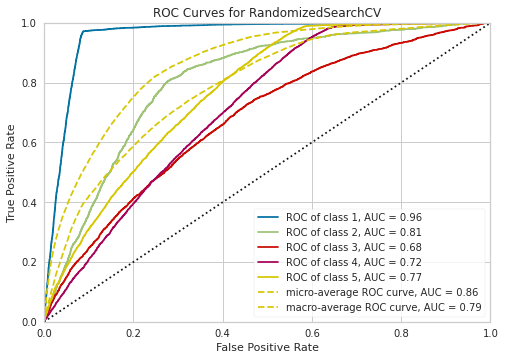

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomizedSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={1: 1, 2: 2, 3: 3, 4: 4, 5: 5},
       estimator=RandomizedSearchCV(cv=10,
                                    estimator=Pipeline(steps=[('preprocessamento',
                                                               ColumnTransformer(transformers=[('numerico',
                                                                                                Pipeline(steps=[('fillna',
                                                                                                                 SimpleImputer()),
                                                                                                                ('scaler',
                                                                                                                 MinMaxScaler())...
                                                                                                 'reviewer_state',
                                                                                                 'mes',
                                                                                                 'dia'])])),
                                                              ('classifier',
                                                               GradientBoostingClassifier(max_features='sqrt'))]),
                                    n_iter=100, n_jobs=4,
                                    param_distributions={'classifier__max_depth': [3,
                                                                                   4],
                                                         'classifier__min_samples_leaf': [2,
                                                                                          10,
                                                                                          0.1,
                                                                                          0.2,
                                                                                          0.05],
                                                         'classifier__min_samples_split': [2,
                                                                                           10,
                                                                                           0.1,
                                                                                           0.2,
                                                                                           0.05],
                                                         'preprocessamento__cat__handle_unknown': ['ignore']},
                                    random_state=42, scoring='accuracy'))

In [64]:
roc_multiclasse(modeloxg, X_train, y_train, X_test, y_test)

Possíveis melhorias:
- Entender por que o tdidf não está funcionando
- Diminuir drasticamente o número de categorias nas variaveis de OneHot (principalmente nas categorias do site e marca do produto). Ex: maiores categorias e o resto em "outros"
- Criar mais variáveis no feature engineering para ver se achamos algo mais preditor (incluindo as do tfidf)
- Excluir features sem importância
- Mais interações na procura de hiperparametros e mais espaço de hiperparametros
- Mais dados para treino tirando o sampling